In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv

import IPython.display as display
from PIL import Image

from sklearn.model_selection import train_test_split


In [35]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2.5.0


In [36]:
colon_main = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")

In [37]:
colon_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [5]:
colon_main.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [6]:
colon_main.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [38]:
train_data, test_data = train_test_split(colon_main, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, 
Val Data: 1979, 
Test Data: 1980


In [8]:
colon_main.isCancerous.value_counts()

0    5817
1    4079
Name: isCancerous, dtype: int64

In [ ]:
colon_main.isCancerous.hist()
plt.show()

Text(0, 0.5, 'notCancerous samples')

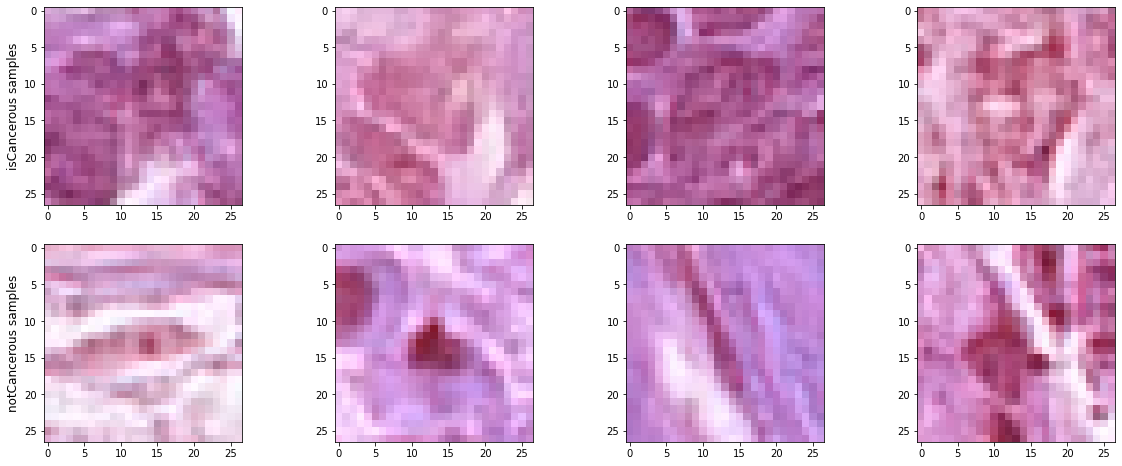

In [15]:
isCancerous = colon_main.loc[colon_main['isCancerous'] == 1].sample(4)
notCancerous = colon_main.loc[colon_main['isCancerous'] == 0].sample(4)

isCancerous_images = []
notCancerous_images = []

for path in isCancerous['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    isCancerous_images.append(image)
    
for path in notCancerous['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    notCancerous_images.append(image)

fig,axis = plt.subplots(2,4,figsize=(20,8))
for i, image in enumerate(isCancerous_images):
    axis[0,i].imshow(image)
axis[0,0].set_ylabel('isCancerous samples', size='large')

for i, image in enumerate(notCancerous_images):
    axis[1,i].imshow(image)
axis[1,0].set_ylabel('notCancerous samples', size='large')



In [ ]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150)

In [55]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model.save("detect_cancer")

In [ ]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.evaluate(test_generator)

In [ ]:
label_names = {'cancer' : 0, 'noCancer' : 1}

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [28]:
colon_main.cellType.value_counts()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64

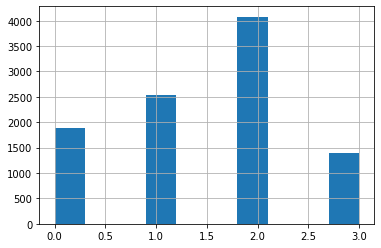

In [29]:
colon_main.cellType.hist()
plt.show()

Text(0, 0.5, 'other')

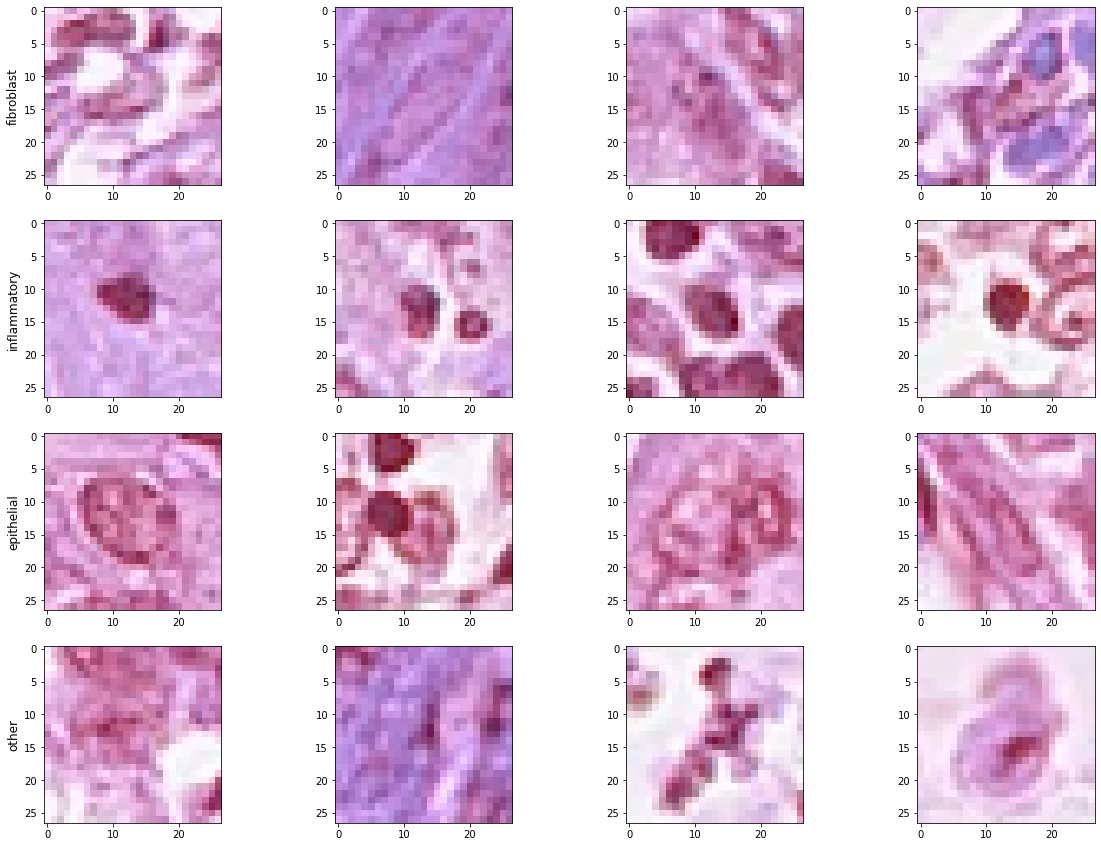

In [39]:
#'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3

fibroblast = colon_main.loc[colon_main['cellType'] == 0].sample(4)
inflammatory = colon_main.loc[colon_main['cellType'] == 1].sample(4)
epithelial = colon_main.loc[colon_main['cellType'] == 2].sample(4)
others = colon_main.loc[colon_main['cellType'] == 3].sample(4)

fibroblast_images = []
inflammatory_images = []
epithelial_images = []
other_images = []

for path in fibroblast['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    fibroblast_images.append(image)
    
for path in inflammatory['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    inflammatory_images.append(image)
    
for path in epithelial['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    epithelial_images.append(image)

for path in others['ImageName']:
    image_path = "./Image_classification_data/patch_images/" + path
    image = cv.imread(image_path)
    other_images.append(image)    

fig,axis = plt.subplots(4,4,figsize=(20,15))
for i, image in enumerate(fibroblast_images):
    axis[0,i].imshow(image)
axis[0,0].set_ylabel('fibroblast', size='large')

for i, image in enumerate(inflammatory_images):
    axis[1,i].imshow(image)
axis[1,0].set_ylabel('inflammatory', size='large')

for i, image in enumerate(epithelial_images):
    axis[2,i].imshow(image)
axis[2,0].set_ylabel('epithelial', size='large')

for i, image in enumerate(other_images):
    axis[3,i].imshow(image)
axis[3,0].set_ylabel('other', size='large')


In [30]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [31]:
cell_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [32]:
cell_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


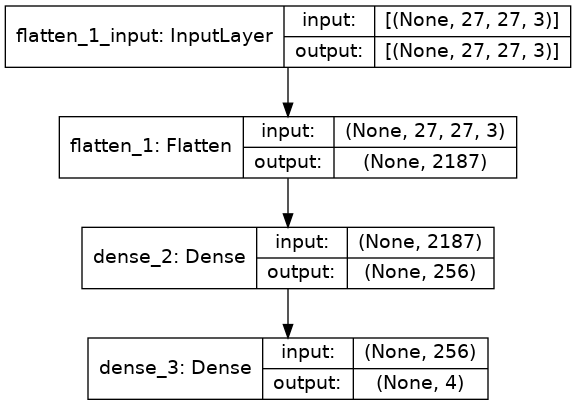

In [33]:
tf.keras.utils.plot_model(cell_model, show_shapes=True)

In [34]:
cell_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [35]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [36]:
cell_history = cell_model.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=150)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
220/220 [==============================] - 4s 16ms/step - loss: 1.2527 - categorical_accuracy: 0.4635 - val_loss: 1.1939 - val_categorical_accuracy: 0.4805
Epoch 2/150
220/220 [==============================] - 3s 15ms/step - loss: 1.1614 - categorical_accuracy: 0.5215 - val_loss: 1.1246 - val_categorical_accuracy: 0.5629
Epoch 3/150
220/220 [==============================] - 3s 15ms/step - loss: 1.0886 - categorical_accuracy: 0.5604 - val_loss: 1.0549 - val_categorical_accuracy: 0.5760
Epoch 4/150
220/220 [==============================] - 3s 15ms/step - loss: 1.0334 - categorical_accuracy: 0.5868 - val_loss: 1.0383 - val_categorical_accuracy: 0.5503
Epoch 5/150
220/220 [==============================] - 3s 15ms/step - loss: 0.9836 - categorical_accuracy: 0.6185 - val_loss: 0.9743 - val_categorical_accuracy: 0.6726
Epoch 6/150
220/220 [==============================] - 4s 16ms/step - loss: 0.9483 - categorical_accuracy: 0.6363 - val_loss: 0.9245 - val_categorical_accuracy:

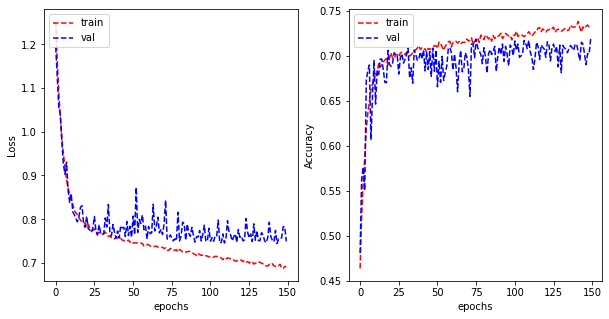

In [37]:
plot_learning_curve(cell_history.history['loss'], cell_history.history['val_loss'], 
                    cell_history.history['categorical_accuracy'], cell_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [38]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
cell_model.evaluate(cell_test_generator)

In [ ]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_test_generator:
        batches = batches + 1
        y_hat = cell_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [ ]:
cell_model.save("predict_celltype")

In [42]:
colon_main_copy = colon_main.copy()

In [43]:
colon_main_copy.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [44]:
colon_main_copy.drop(['cellTypeName'], axis=1, inplace=True)

In [45]:
cell_train_data, cell_val_data = train_test_split(colon_main_copy, test_size=0.2, random_state=42)

print("Train data : {}, \nVal Data: {}".format(cell_train_data.shape[0], cell_val_data.shape[0]))


Train data : 7916, 
Val Data: 1980


In [46]:
cell_train_data.head()

,InstanceID,patientID,ImageName,cellType,isCancerous
3111,8379,18,8379.png,2,1
742,9043,7,9043.png,0,0
6087,20555,37,20555.png,0,0
5669,11310,32,11310.png,3,0
4254,20081,23,20081.png,0,0


In [47]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [48]:
cell_model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [49]:
cell_model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


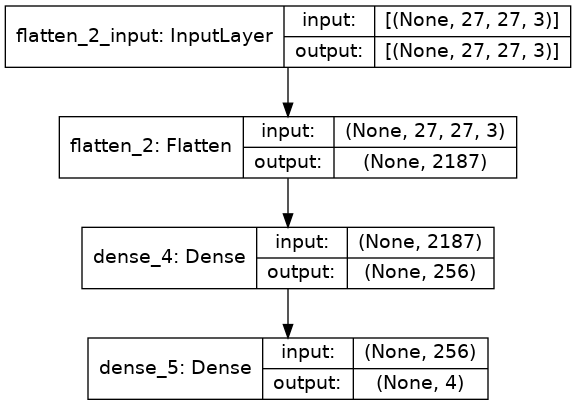

In [50]:
tf.keras.utils.plot_model(cell_model1, show_shapes=True)

In [51]:
cell_model1.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cell_train_data['cellType'] = cell_train_data['cellType'].astype('str')
cell_val_data['cellType'] = cell_val_data['cellType'].astype('str')

cell_train_datagen1 = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_val_datagen1 = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

cell_train_generator1 = cell_train_datagen1.flow_from_dataframe(
        dataframe=cell_train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator1 = cell_val_datagen1.flow_from_dataframe(
        dataframe=cell_val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
cell_history1 = cell_model1.fit_generator(cell_train_generator1, validation_data = cell_validation_generator1, epochs=150)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
294/294 [==============================] - 5s 15ms/step - loss: 1.2325 - categorical_accuracy: 0.4660 - val_loss: 1.1995 - val_categorical_accuracy: 0.5500
Epoch 2/150
294/294 [==============================] - 4s 14ms/step - loss: 1.1232 - categorical_accuracy: 0.5428 - val_loss: 1.1024 - val_categorical_accuracy: 0.5581
Epoch 3/150
294/294 [==============================] - 4s 15ms/step - loss: 1.0439 - categorical_accuracy: 0.5875 - val_loss: 1.0188 - val_categorical_accuracy: 0.5798
Epoch 4/150
294/294 [==============================] - 4s 14ms/step - loss: 0.9793 - categorical_accuracy: 0.6194 - val_loss: 0.9788 - val_categorical_accuracy: 0.6697
Epoch 5/150
294/294 [==============================] - 4s 14ms/step - loss: 0.9297 - categorical_accuracy: 0.6474 - val_loss: 0.9411 - val_categorical_accuracy: 0.6682
Epoch 6/150
294/294 [==============================] - 4s 14ms/step - loss: 0.8918 - categorical_accuracy: 0.6674 - val_loss: 0.8869 - val_categorical_accuracy:

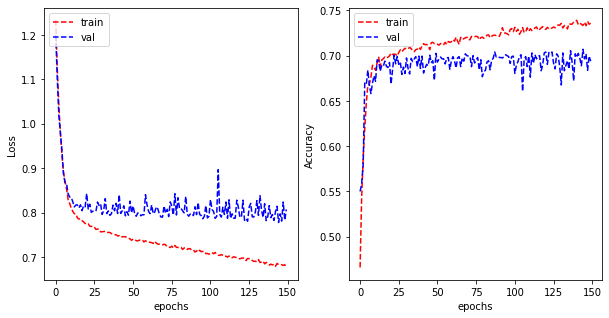

In [54]:
plot_learning_curve(cell_history1.history['loss'], cell_history1.history['val_loss'], 
                    cell_history1.history['categorical_accuracy'], cell_history1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [55]:
cell_model1.save("predict_celltype_extra")

INFO:tensorflow:Assets written to: predict_celltype_extra/assets


In [56]:
colon_extra = pd.read_csv("./Image_classification_data/data_labels_extraData.csv")

In [57]:
colon_extra.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [71]:
from sklearn.datasets import make_blobs

X, colon_extra['cellType'], = make_blobs(n_samples=10384, centers=4, n_features=1, random_state=0)

In [72]:
colon_extra.head()

,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,0
1,12682,61,12682.png,0,1
2,12683,61,12683.png,0,2
3,12684,61,12684.png,0,3
4,12685,61,12685.png,0,3


In [73]:
colon_extra['cellType'] = colon_extra['cellType'].astype('str')

cell_predict_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

cell_predict_generator = cell_predict_datagen.flow_from_dataframe(
        dataframe=colon_extra,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 10384 validated image filenames belonging to 4 classes.


In [74]:
cell_model1.evaluate(cell_predict_generator)

10384/10384 [==============================] - 17s 2ms/step - loss: 3.1593 - categorical_accuracy: 0.2486


[3.159327268600464, 0.24855546653270721]

In [75]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

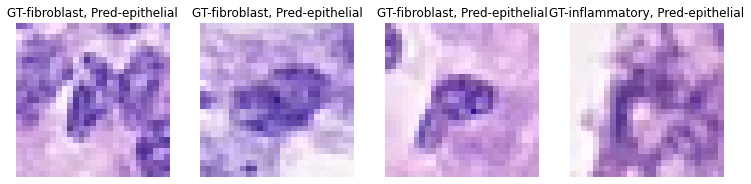

In [81]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_predict_generator:
        batches = batches + 1
        y_hat = cell_model1.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:you syou
            break
        
        plt.axis('off')

# Lenet model - Predicting CellType

In [31]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_type_train_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

cell_type_val_datagen = ImageDataGenerator(
                                rescale=1./255, 
                                data_format='channels_last',
                                rotation_range=30, 
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range = 0.2,
                                featurewise_std_normalization=True,
                                samplewise_std_normalization=True)

batch_size = 32

cell_type_train_generator = cell_type_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_type_validation_generator = cell_type_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:349: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:356: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


In [49]:
reg_lambda = 0.001

cell_type_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
  
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(48, (5, 5), padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [50]:
cell_type_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 27, 27, 32)        2432      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 9, 9, 48)          38448     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 48)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               196864    
_________________________________________________________________
dense_17 (Dense)             (None, 84)               

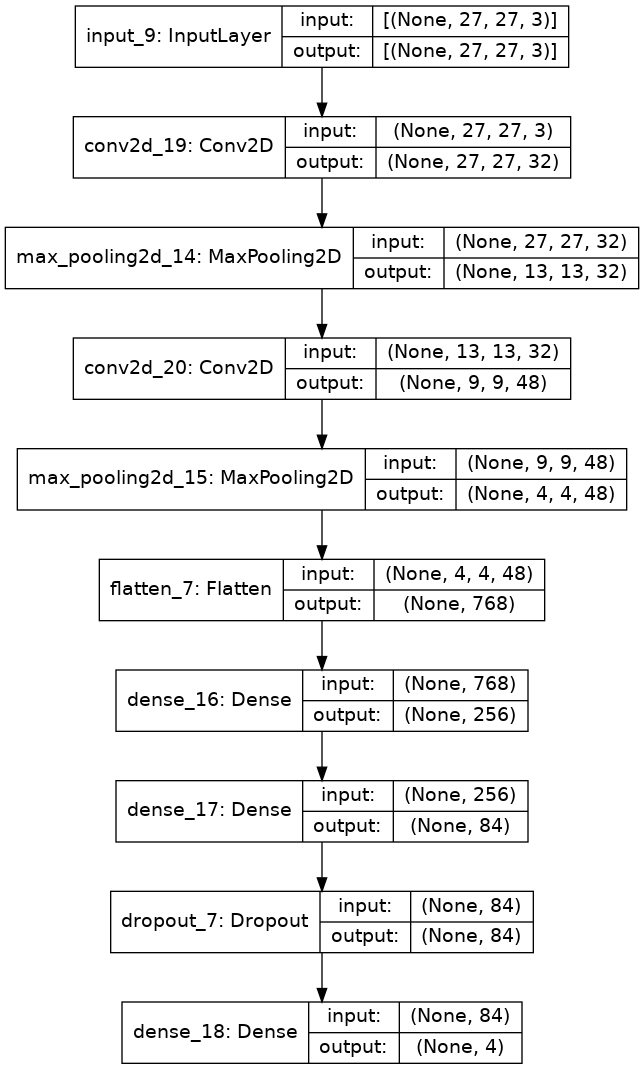

In [51]:
tf.keras.utils.plot_model(cell_type_model, show_shapes=True)

In [52]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
cell_type_model .compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [53]:
history = cell_type_model.fit_generator(cell_type_train_generator, 
                                    validation_data = cell_type_validation_generator, 
                                    epochs=150)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator s

Epoch 1/150
186/186 [==============================] - 15s 78ms/step - loss: 0.9810 - categorical_accuracy: 0.5995 - val_loss: 0.9061 - val_categorical_accuracy: 0.6523
Epoch 2/150
186/186 [==============================] - 14s 74ms/step - loss: 0.8820 - categorical_accuracy: 0.6552 - val_loss: 0.8148 - val_categorical_accuracy: 0.6837
Epoch 3/150
186/186 [==============================] - 14s 75ms/step - loss: 0.8318 - categorical_accuracy: 0.6812 - val_loss: 0.8608 - val_categorical_accuracy: 0.6609
Epoch 4/150
186/186 [==============================] - 14s 76ms/step - loss: 0.7924 - categorical_accuracy: 0.6938 - val_loss: 0.7320 - val_categorical_accuracy: 0.7165
Epoch 5/150
186/186 [==============================] - 14s 76ms/step - loss: 0.7668 - categorical_accuracy: 0.7041 - val_loss: 0.7503 - val_categorical_accuracy: 0.7014
Epoch 6/150
186/186 [==============================] - 14s 76ms/step - loss: 0.7558 - categorical_accuracy: 0.7128 - val_loss: 0.7154 - val_categorical_acc

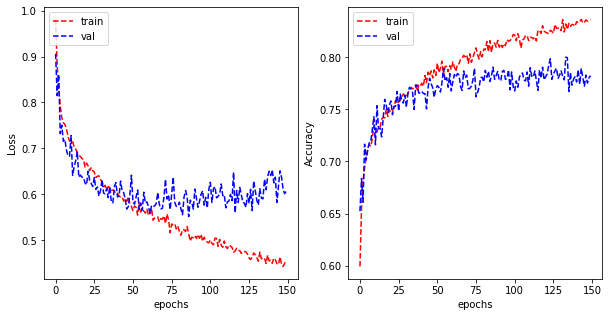

In [56]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [61]:
reg_lambda = 0.001

cell_type_model_reg = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
  
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(48, (5, 5), padding='valid', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(64, (3, 3), padding='valid', activation='relu',),
    tf.keras.layers.MaxPool2D(strides=2, pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [62]:
cell_type_model_reg.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 27, 27, 32)        2432      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 9, 48)          38448     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 2, 64)          27712     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 64)              

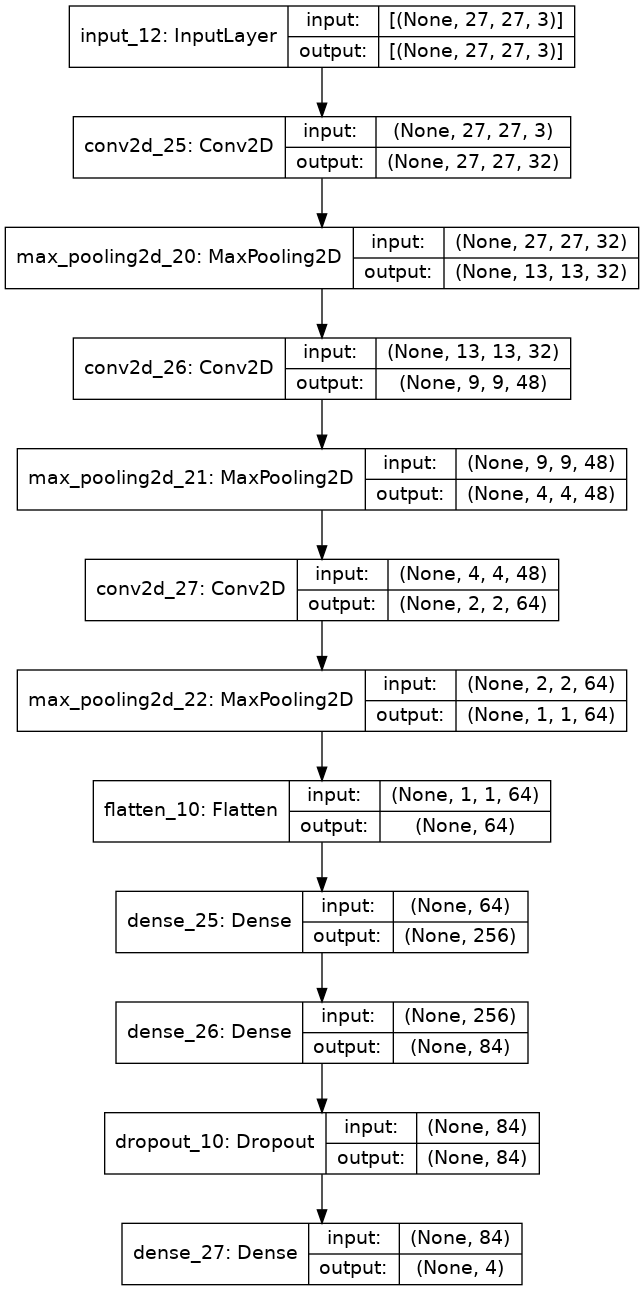

In [64]:
tf.keras.utils.plot_model(cell_type_model_reg, show_shapes=True)

In [66]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
cell_type_model_reg.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

In [68]:
cell_history_reg = cell_type_model_reg.fit_generator(cell_type_train_generator, 
                                    validation_data = cell_type_validation_generator, 
                                    epochs=100)

Epoch 1/100
186/186 [==============================] - 14s 78ms/step - loss: 0.9518 - categorical_accuracy: 0.6518 - val_loss: 0.9155 - val_categorical_accuracy: 0.6448
Epoch 2/100
186/186 [==============================] - 14s 76ms/step - loss: 0.9033 - categorical_accuracy: 0.6729 - val_loss: 0.8329 - val_categorical_accuracy: 0.6837
Epoch 3/100
186/186 [==============================] - 14s 77ms/step - loss: 0.8713 - categorical_accuracy: 0.6838 - val_loss: 0.8144 - val_categorical_accuracy: 0.6988
Epoch 4/100
186/186 [==============================] - 15s 82ms/step - loss: 0.8425 - categorical_accuracy: 0.6936 - val_loss: 0.7792 - val_categorical_accuracy: 0.7191
Epoch 5/100
186/186 [==============================] - 14s 76ms/step - loss: 0.8217 - categorical_accuracy: 0.7096 - val_loss: 0.7528 - val_categorical_accuracy: 0.7317
Epoch 6/100
186/186 [==============================] - 14s 75ms/step - loss: 0.8096 - categorical_accuracy: 0.7138 - val_loss: 0.7743 - val_categorical_acc

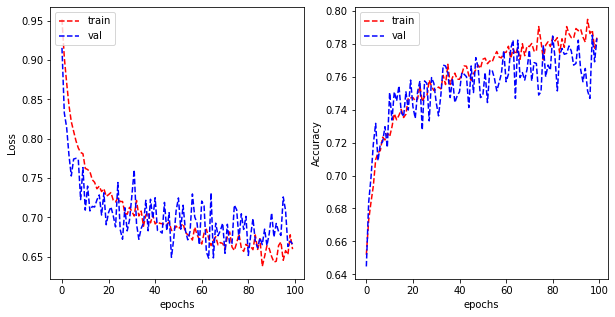

In [69]:
plot_learning_curve(cell_history_reg.history['loss'], cell_history_reg.history['val_loss'], 
                    cell_history_reg.history['categorical_accuracy'], cell_history_reg.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')